## Prepare data

In [33]:
!pip install ucimlrepo

### Iris data

In [34]:
from ucimlrepo import fetch_ucirepo

iris_data = fetch_ucirepo(id=53)
rows_to_drop = []

for index, row in iris_data.data.original.iterrows():
  if row['class'] == 'Iris-versicolor':
    iris_data.data.original.at[index, 'class'] = 0
  elif row['class'] == 'Iris-virginica':
    iris_data.data.original.at[index, 'class'] = 1
  else:
    rows_to_drop.append(index)

iris_data.data.original.drop(index=rows_to_drop, inplace=True)
iris_data.data.original.reset_index(drop=True, inplace=True)

#### Augmentation

In [35]:
import numpy as np
import pandas as pd

def add_gaussian_noise(data, num_samples, mean=0, std_dev=0.05):
    augmented_data = []
    for _ in range(num_samples):
        noise = np.random.normal(mean, std_dev, (50,4))
        noise = np.column_stack((noise, [0]*50))
        noisy_data = data + noise
        augmented_data.append(noisy_data)
    return pd.DataFrame(np.vstack(augmented_data), columns=data.columns)

iris_0 = iris_data.data.original[iris_data.data.original['class'] == 0]
iris_1 = iris_data.data.original[iris_data.data.original['class'] == 1]

iris_0_aug = add_gaussian_noise(iris_0, num_samples=3)
iris_1_aug = add_gaussian_noise(iris_1, num_samples=3)

iris_data_aug = pd.concat([iris_0, iris_0_aug, iris_1, iris_1_aug])
iris_data_aug = iris_data_aug.sample(frac=1).reset_index(drop=True)

iris_X = iris_data_aug.iloc[:,0:4]
iris_y = iris_data_aug.iloc[:,4:5]

#### Review data before/after augmentation

In [ ]:
!pip install --upgrade seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

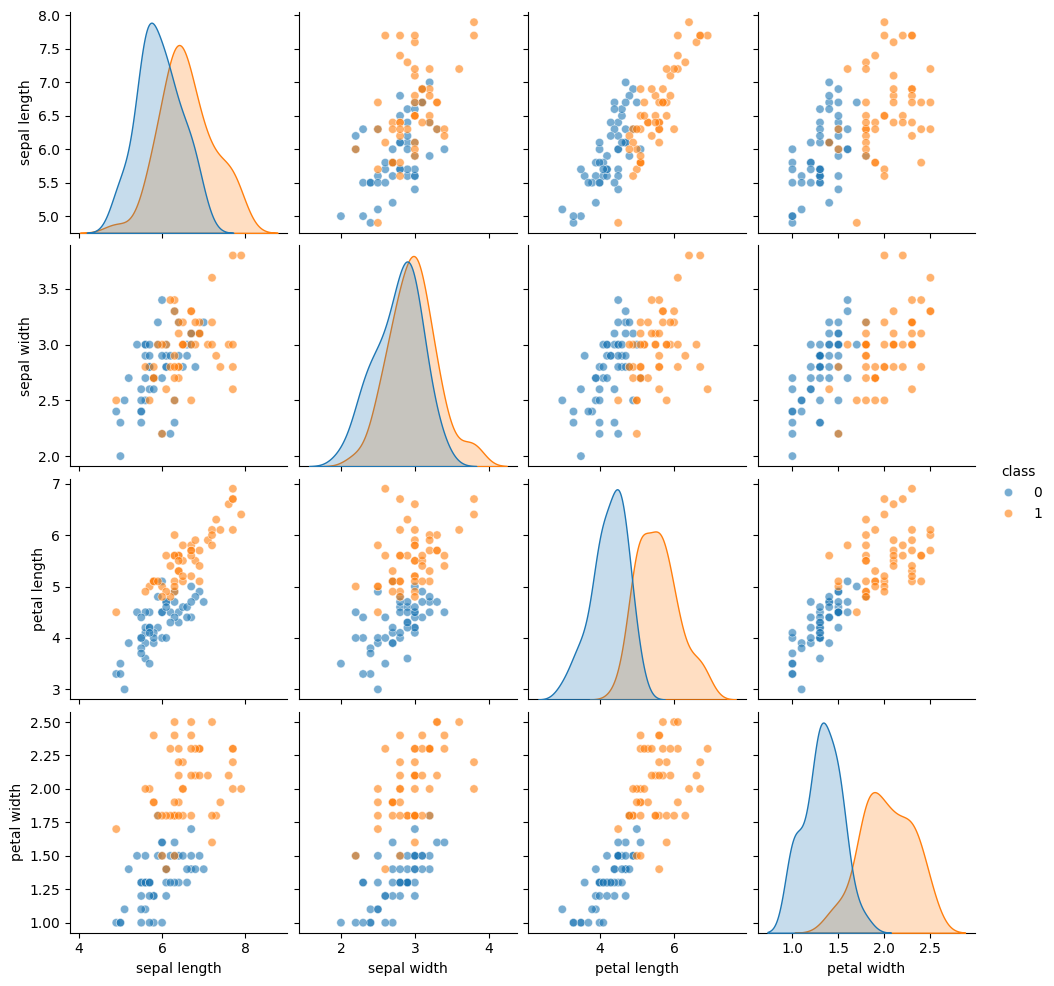

In [ ]:
#Before augmentation

iris_df = pd.DataFrame(data=iris_data.data.original)

pair_plot = sns.pairplot(iris_df, hue='class', markers='o', plot_kws={'alpha': 0.6})

plt.show()

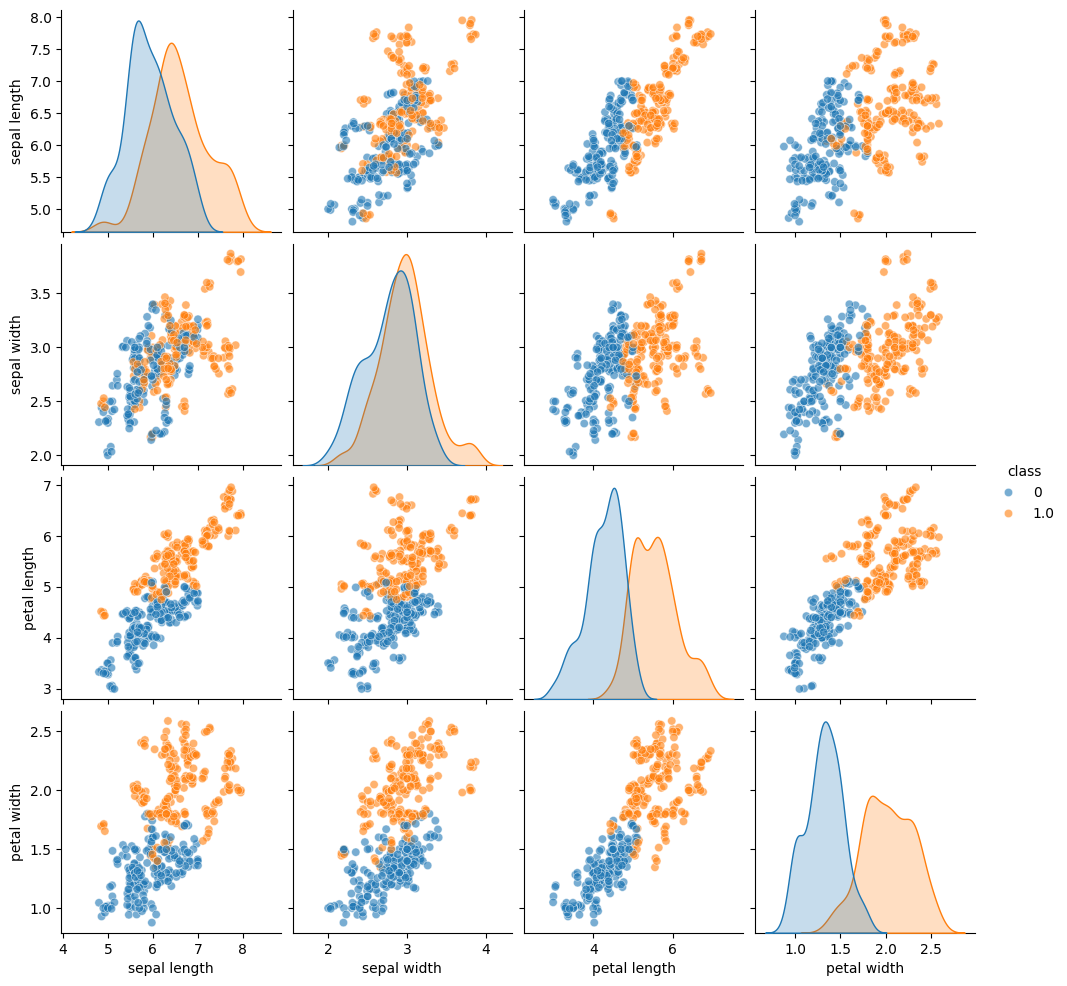

In [ ]:
# After augmentation

iris_df = pd.DataFrame(data=iris_data_aug)

pair_plot = sns.pairplot(iris_df, hue='class', markers='o', plot_kws={'alpha': 0.6})

plt.show()

### Breast cancer data

In [36]:
from ucimlrepo import fetch_ucirepo

breast_cancer_data = fetch_ucirepo(id=15)
rows_to_drop = []
columns_to_drop = ['Sample_code_number']

breast_cancer_data.data.original.drop(columns=columns_to_drop, inplace=True)
breast_cancer_data.data.original.dropna(inplace=True)

for index, row in breast_cancer_data.data.original.iterrows():
  if row['Class'] == 2:
    breast_cancer_data.data.original.at[index, 'Class'] = 0
  if row['Class'] == 4:
    breast_cancer_data.data.original.at[index, 'Class'] = 1

breast_cancer_data.data.original.reset_index(drop=True, inplace=True)

breast_cancer_X = breast_cancer_data.data.original.iloc[:,0:9]
breast_cancer_y = breast_cancer_data.data.original.iloc[:,9:10]

## Define neuron

In [37]:
class SigmoidNeuron:
    def __init__(self, input_dim, learning_rate=0.01, epochs=1000):
        self.weights = np.zeros(input_dim + 1) # + bias
        self.learning_rate = learning_rate
        self.epochs = epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, y, error_threshold=0.05):
        data = X
        X = np.c_[np.ones(X.shape[0]), X] # + x0
        y = np.c_[y]
        total_error = float('inf')
        epoch = 0
        hist_errors = []
        hist_accuracy = []

        while total_error > error_threshold and epoch < self.epochs:
            total_error = 0
            gradientSum = np.zeros(self.weights.shape[0])
            for i in range(X.shape[0]):
              a = np.dot(X[i], self.weights)
              y_pred = self.sigmoid(a)
              t = y[i][0]
              for k in range(self.weights.shape[0]):
                gradientSum[k] = gradientSum[k] + (y_pred - t) * y_pred * (1 - y_pred) * X[i][k]

              error = (t - y_pred) ** 2
              total_error = total_error + error

            for k in range(self.weights.shape[0]):
              self.weights[k] = self.weights[k] - self.learning_rate * (gradientSum[k] / X.shape[0])

            preds = self.predict(data)
            accurate = 0
            for i in range(X.shape[0]):
              if (preds[i] == y[i][0]):
                accurate += 1
            accuracy = accurate/X.shape[0]

            total_error = total_error / X.shape[0]
            hist_errors += [total_error]
            hist_accuracy += [accuracy]
            epoch += 1
            print(f'Epoch: {epoch}, Accuracy: {accuracy} Total error: {total_error}')

        return (hist_errors, hist_accuracy)

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        result = []

        for i in range(X.shape[0]):
          y_pred = np.dot(X[i], self.weights)
          pred = self.sigmoid(y_pred)
          result += [round(pred)]

        return result

    def evaluate(self, X, y):
        data = X
        X = np.c_[np.ones(X.shape[0]), X]
        y = np.c_[y]

        totalError = 0
        for i in range(X.shape[0]):
          a = 0
          for k in range(self.weights.shape[0]):
            a = a + self.weights[k] * X[i][k]
          y_pred = self.sigmoid(a)
          error = (y[i][0] - y_pred) ** 2
          totalError = totalError + error

        preds = self.predict(data)
        accurate = 0
        for i in range(X.shape[0]):
          if (preds[i] == y[i][0]):
            accurate += 1
        accuracy = accurate/X.shape[0]

        return (accuracy, totalError/X.shape[0])

## Training

### Iris model training

Epoch: 1, Accuracy: 0.509375 Total error: 0.25
Epoch: 2, Accuracy: 0.509375 Total error: 0.2476291442712102
Epoch: 3, Accuracy: 0.509375 Total error: 0.24662282316881248
Epoch: 4, Accuracy: 0.509375 Total error: 0.24598362736107923
Epoch: 5, Accuracy: 0.509375 Total error: 0.24544219312539933
Epoch: 6, Accuracy: 0.509375 Total error: 0.24492747524124864
Epoch: 7, Accuracy: 0.509375 Total error: 0.24442077284218602
Epoch: 8, Accuracy: 0.509375 Total error: 0.24391716245184947
Epoch: 9, Accuracy: 0.509375 Total error: 0.2434153497609933
Epoch: 10, Accuracy: 0.509375 Total error: 0.24291499602118533
Epoch: 11, Accuracy: 0.509375 Total error: 0.24241601355358283
Epoch: 12, Accuracy: 0.509375 Total error: 0.2419183803906074
Epoch: 13, Accuracy: 0.509375 Total error: 0.24142209164317743
Epoch: 14, Accuracy: 0.509375 Total error: 0.24092714679209407
Epoch: 15, Accuracy: 0.509375 Total error: 0.24043354638568298
Epoch: 16, Accuracy: 0.509375 Total error: 0.23994129118893492
Epoch: 17, Accuracy

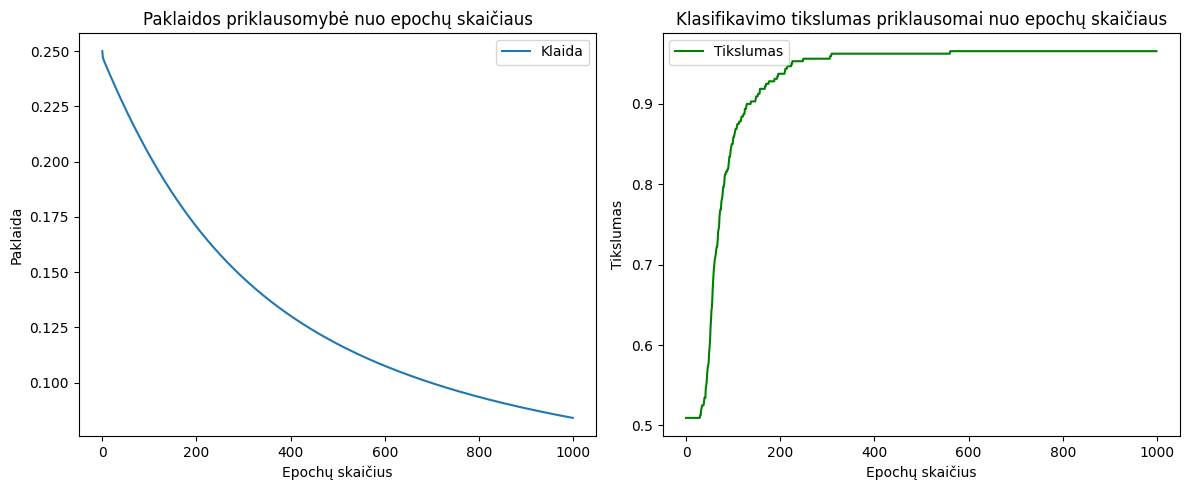

Loss for test data: 0.09648905331598534, Accuracy: 0.925


In [38]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.2, shuffle=True)

iris_neuron = SigmoidNeuron(input_dim=iris_X.shape[1], learning_rate=0.1, epochs=1000)
(error, accuracy) = iris_neuron.train(X_train, y_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(iris_neuron.epochs), error, label='Klaida')
plt.xlabel('Epochų skaičius')
plt.ylabel('Paklaida')
plt.title('Paklaidos priklausomybė nuo epochų skaičiaus')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(iris_neuron.epochs), accuracy, label='Tikslumas', color='g')
plt.xlabel('Epochų skaičius')
plt.ylabel('Tikslumas')
plt.title('Klasifikavimo tikslumas priklausomai nuo epochų skaičiaus')
plt.legend()

plt.tight_layout()
plt.show()

(accuracy, loss) = iris_neuron.evaluate(X_test, y_test)
print(f'Loss for test data: {loss}, Accuracy: {accuracy}')

### Breast cancer training

Epoch: 1, Accuracy: 0.35714285714285715 Total error: 0.25
Epoch: 2, Accuracy: 0.35714285714285715 Total error: 0.22837840478632745
Epoch: 3, Accuracy: 0.35714285714285715 Total error: 0.2234717268175178
Epoch: 4, Accuracy: 0.358974358974359 Total error: 0.2188328107015234
Epoch: 5, Accuracy: 0.45604395604395603 Total error: 0.2144474817035253
Epoch: 6, Accuracy: 0.5805860805860806 Total error: 0.21030241118686552
Epoch: 7, Accuracy: 0.6465201465201466 Total error: 0.2063839421429529
Epoch: 8, Accuracy: 0.7051282051282052 Total error: 0.2026784105813661
Epoch: 9, Accuracy: 0.7545787545787546 Total error: 0.19917240206711628
Epoch: 10, Accuracy: 0.7710622710622711 Total error: 0.19585293873841075
Epoch: 11, Accuracy: 0.8113553113553114 Total error: 0.1927076078420523
Epoch: 12, Accuracy: 0.826007326007326 Total error: 0.1897246431268627
Epoch: 13, Accuracy: 0.8754578754578755 Total error: 0.18689296943375877
Epoch: 14, Accuracy: 0.8736263736263736 Total error: 0.18420221941700135
Epoch: 

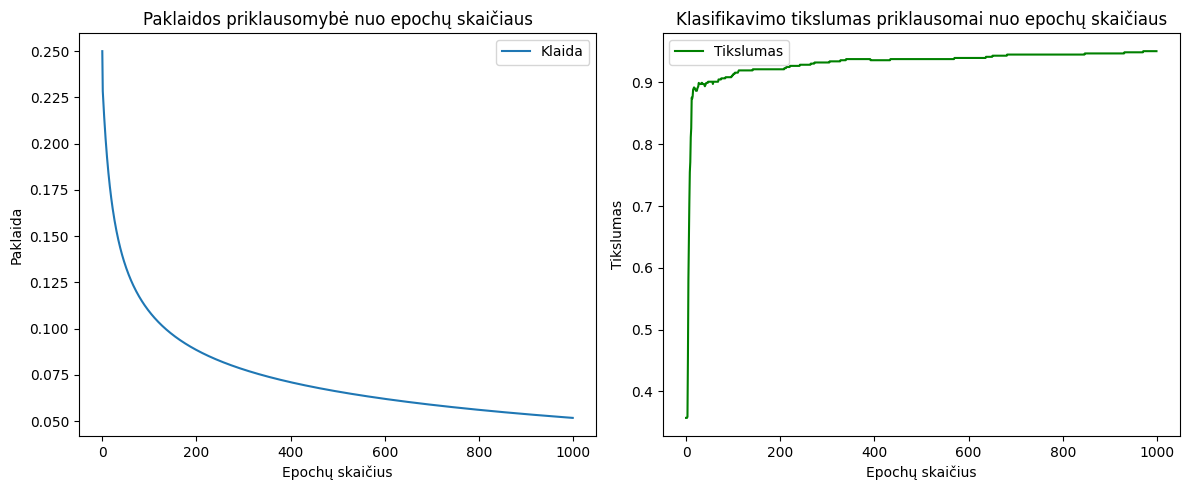

Loss for test data: 0.0596796062221548, Accuracy: 0.9416058394160584


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_X, breast_cancer_y, test_size=0.2, shuffle=True)

breast_cancer_neuron = SigmoidNeuron(input_dim=breast_cancer_X.shape[1], learning_rate=0.1, epochs=1000)
(error, accuracy) = breast_cancer_neuron.train(X_train, y_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(breast_cancer_neuron.epochs), error, label='Klaida')
plt.xlabel('Epochų skaičius')
plt.ylabel('Paklaida')
plt.title('Paklaidos priklausomybė nuo epochų skaičiaus')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(breast_cancer_neuron.epochs), accuracy, label='Tikslumas', color='g')
plt.xlabel('Epochų skaičius')
plt.ylabel('Tikslumas')
plt.title('Klasifikavimo tikslumas priklausomai nuo epochų skaičiaus')
plt.legend()

plt.tight_layout()
plt.show()

(accuracy, loss) = breast_cancer_neuron.evaluate(X_test, y_test)
print(f'Loss for test data: {loss}, Accuracy: {accuracy}')